In [1]:
%matplotlib inline
import seaborn
import matplotlib.pyplot as plt
import numpy as np
from numpy.random import randn, randint, uniform, choice

# Metropolis

Basic idea - start at some random location. Flip a coin to choose to move to neighbor either to the left or the right. If the neighbor is larger, always go. Otherwise, probabilistically go based on $p = p_{neig}/p_{here}$. We may start in a very low probability area, so we 'burn in' the algorithm by ignoring the the results for awhile, hoping that we end up in a more representative area of the distribution.

In [2]:
# metropolis algorithm for discrete distribution and
# explicit logic

def metropolis_d1(a, trials, burn_in):
    N = len(a)
    counts = np.zeros(N)
    idx = randint(0, N)  # current position

    for i in range(trials + burn_in):
        move = (idx + choice([-1, 1])) % N
    
        if a[move] >= a[idx]: #always move if new population is higher
            idx = move
        else:
            # probabilisitically move based on ratio of new/current population
            if uniform() < a[move] / a[idx]:
                idx = move

        if i >= burn_in:
            counts[idx] += 1
    return counts/sum(counts)

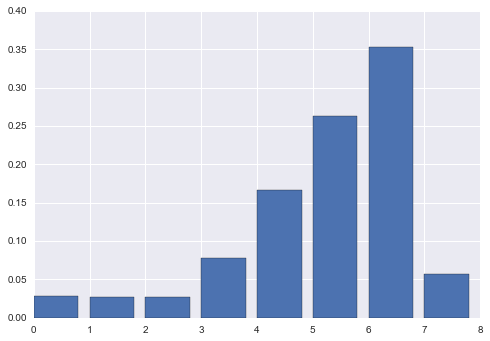

In [3]:
a = np.array([10, 10, 10, 30, 60, 90, 120, 20])
counts = metropolis_d1(a, 10000, 1000)
plt.bar(range(len(counts)), counts);

That code was explicit, but kind of dumb. If the size of the neighbor is larger than the current location than `a[move] / a[i] > 1` and thus `uniform` will always be less than it, so we can collapse the move decision down to one choice.

In [4]:
# now let's be smarter about the algorithm

def metropolis_d2(a, trials, burn_in):
    N = len(a)
    counts = np.zeros(N)
    idx = randint(0, N)  # current position

    for i in range(trials + burn_in):
        move = (idx + choice([-1, 1])) % N
        if uniform() < a[move] / a[idx]:
                idx = move

        if i >= burn_in:
            counts[idx] += 1        
    return counts/sum(counts)

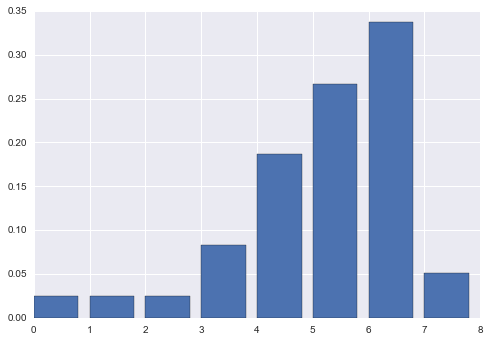

In [5]:
counts = metropolis_d2(a, 10000, 100)
plt.bar(range(len(counts)), counts);

This is exceedingly dumb, as we can compute the distribution with

In [6]:
%precision 3
a/sum(a)

array([ 0.029,  0.029,  0.029,  0.086,  0.171,  0.257,  0.343,  0.057])

But the real use is for continuous distributions. Want to be able to jump some arbitrary distance $\mathcal N(0, \sigma)$, not just to the nearest neighbors.

In [7]:
def metropolis(prior, sigma, prob_fn, steps, burn_in):
    theta = prior
    data = []
    for i in range(steps + burn_in):
        theta_neig = theta + randn()*sigma
       
        p_neig = prob_fn(theta_neig) * theta_neig
        p_cur = max(prob_fn(theta)* theta, 1.e-80) # avoid / 0
        p_move = min(1, p_neig / p_cur)
        if uniform() < p_move:
            theta = theta_neig
        if i >= burn_in:
            data.append(theta)

    return np.array(data)

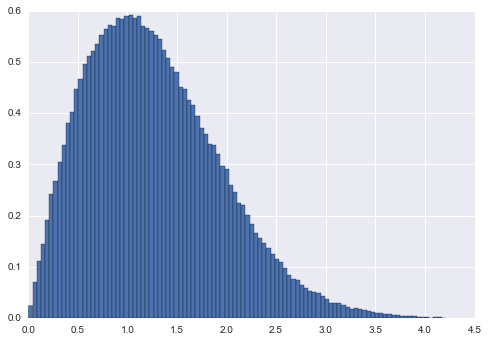

In [8]:
from math import exp, sqrt, pi

def sdev(theta):
    return exp(-theta**2/2.) / sqrt(2 * pi)

data = metropolis(0, .1, sdev, 300000, 100)
plt.hist(data, 100, normed=1);

This won't work well because we are using a Gaussian to draw from the samples.

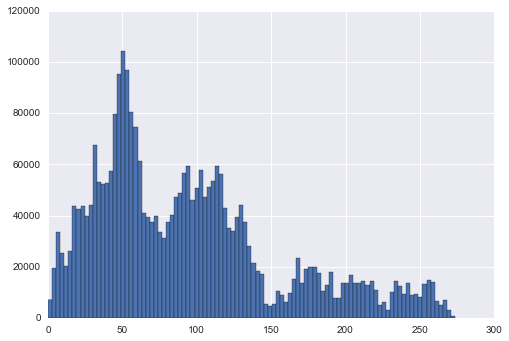

In [9]:
def flat(theta):
    return 0.01
data = metropolis(0, .1, flat, 3000000, 100)
plt.hist(data, 100);

In [10]:
from scipy.stats import beta

def prior_bern(theta):  
    if theta > 1 or theta < 0:
        return 0.
    return beta.pdf(theta, prior_bern.a, prior_bern.b)

def likelihood_bern(theta, data):
    if theta > 1 or theta < 0:
        return 0
    z = sum(data)
    N = len(data)    
    return theta**z * (1-theta)**(N-z)

def rel_prob_bern(theta, data):
    return likelihood_bern(theta, data) * prior_bern(theta)      

In [11]:
traj_len = 50000
trajectory = np.zeros(traj_len+1)

tails, heads = 14, 14
prior_bern.a = 1
prior_bern.b = 1

amount_data = 9
data = np.array([0]*tails*amount_data + [1]*heads*amount_data)
proposalSD = .1

# precompute all jumps and transition probabilities
# just to make things a bit faster
probs = uniform(0, 1, traj_len)

for i in range(traj_len):
    pos = trajectory[i]
    jump = pos + randn() * proposalSD
    prob_jump = rel_prob_bern(jump, data)
    prob_here = max(rel_prob_bern(pos, data), 1e-80) # avoid / 0
    prob_accept = min(1,  prob_jump / prob_here)
    if uniform() <= prob_accept:
        pos = jump
    trajectory[i+1] = pos

bias est: 39.23
bias:     50.00
std:      0.207


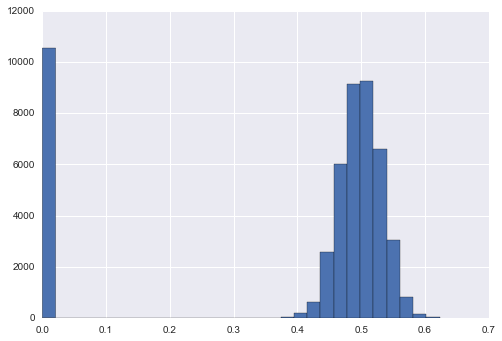

In [12]:
# let first 1000 be burn-in
burn_in = 1000
plt.hist(trajectory[burn_in:], 30);
bias_est = np.mean(trajectory[burn_in:])
bias= heads/(heads+tails)
             
print("bias est: {:.2f}\nbias:     {:.2f}".format(bias_est*100, bias*100))
print("std:      {:.3f}".format(np.std(trajectory[burn_in:])))

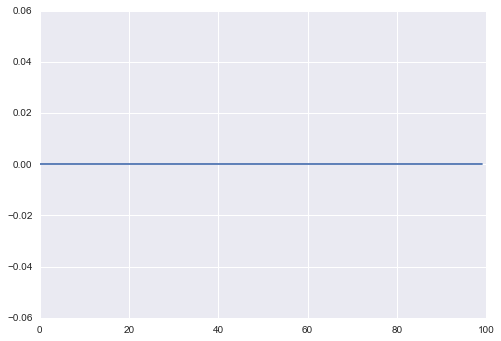

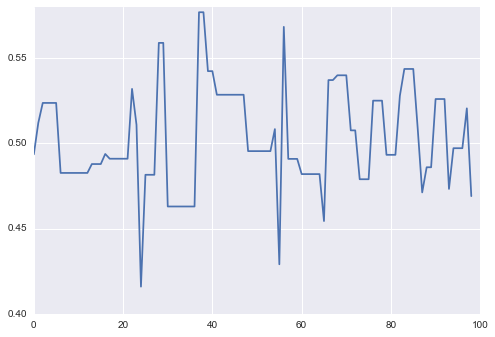

In [13]:
plt.plot(trajectory[:100])
plt.show()
plt.plot(trajectory[-100:-1]);